# Required

In [1]:
import os
import pandas as pd
import zipfile
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
import shutil

import torch.optim as optim
from tqdm import tqdm
import torchvision.transforms as T

import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
train_dir = "/content/gdrive/MyDrive/ColabNotebooks/TrainIJCNN2013.zip"
test_dir = "/content/gdrive/MyDrive/ColabNotebooks/TestIJCNN2013.zip"
annotations_path = "/content/gdrive/MyDrive/ColabNotebooks/gt.txt"

TrainIJCNN2013.zip exists: True
TestIJCNN2013.zip exists: True


In [6]:
local_zip = 'TrainIJCNN2013.zip'
zip_ref = zipfile.ZipFile(train_dir, 'r')
zip_ref.extractall('/content')
zip_ref.close()

local_zip = 'TestIJCNN2013.zip'
zip_ref = zipfile.ZipFile(test_dir, 'r')
zip_ref.extractall('/content')
zip_ref.close()

FileNotFoundError: [Errno 2] No such file or directory: '/content/TrainIJCNN2013.zip'

In [50]:
shutil.copy(annotations_path, train_dir)
shutil.copy(annotations_path, test_dir)

print("Το αρχείο 'gt.txt' μετακινήθηκε επιτυχώς στους φακέλους TrainIJCNN2013 και TestIJCNN2013.")

Το αρχείο 'gt.txt' μετακινήθηκε επιτυχώς στους φακέλους TrainIJCNN2013 και TestIJCNN2013.


In [41]:
# Έλεγχος του αρχείου gt.txt
with open('/content/TrainIJCNN2013/gt.txt', 'r') as file:
    lines = file.readlines()

# Παράδειγμα γραμμής
print("Παράδειγμα γραμμής στο gt.txt:")
print(lines[0])

# Επαναφορά annotations χωρίς το header
annotations = []
with open('/content/TrainIJCNN2013/gt.txt', 'r') as file:
    lines = file.readlines()[1:]  # Παράλειψη της πρώτης γραμμής (header)
    for line in lines:
        parts = line.strip().split(',')
        filename = parts[0]
        bbox = list(map(int, parts[1:5]))
        label = int(parts[5])
        annotations.append((filename, bbox, label))

# Έλεγχος πρώτων δεδομένων
print("Πρώτη γραμμή annotations:")
print(annotations[0])


Παράδειγμα γραμμής στο gt.txt:
filename,x1,y1,x2,y2,class

Πρώτη γραμμή annotations:
('/content/TrainIJCNN2013/00000.ppm', [774, 411, 815, 446], 11)


# Faste-RCNN

In [42]:
# Φόρτωση προ-εκπαιδευμένου μοντέλου Faster R-CNN
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Έλεγχος αν έχουμε πρόσβαση σε GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(f"Using device: {device}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda


In [52]:
# Custom Dataset Class για το GTSDB
class TrafficSignDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transforms=None):
        # Φορτώνουμε τα annotations από το αρχείο
        self.annotations = []
        with open(annotations_file, 'r') as file:
            lines = file.readlines()
            for line in lines:
                # Εξασφαλίζουμε ότι κάθε γραμμή έχει τη σωστή μορφή
                parts = line.strip().split(';')  # Χρήση `;` ως διαχωριστικό, δεδομένου ότι το GTSDB το χρησιμοποιεί
                if len(parts) < 6:
                    continue  # Παραλείπουμε γραμμές με μη έγκυρα δεδομένα
                filename = parts[0]
                try:
                    bbox = list(map(int, parts[1:5]))  # Μετατροπή σε ακέραιους
                    label = int(parts[5])
                    self.annotations.append((filename, bbox, label))
                except ValueError:
                    print(f"Invalid data in line: {line.strip()}")
                    continue

        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Διαχωρισμός δεδομένων
        filename, bbox, label = self.annotations[idx]
        img_path = os.path.join(self.img_dir, filename)

        # Φόρτωση εικόνας
        image = Image.open(img_path).convert("RGB")
        boxes = torch.as_tensor([bbox], dtype=torch.float32)
        labels = torch.as_tensor([label], dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            image = self.transforms(image)

        return image, target


# Μετασχηματισμοί

transform = T.Compose([
    T.ToTensor(),
])

# Ορισμός paths
train_dataset = TrafficSignDataset(
    annotations_file=annotations_path,
    img_dir=train_dir,
    transforms=transform
)

test_dataset = TrafficSignDataset(
    annotations_file=annotations_path,
    img_dir=test_dir,
    transforms=transform
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [39]:
# Ορισμός optimizer
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

# Function για εκπαίδευση
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    for images, targets in tqdm(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Βήμα προς τα εμπρός
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        # Βήμα προς τα πίσω
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    return total_loss / len(data_loader)

# Εκπαίδευση
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    print(f"Epoch #{epoch + 1} Loss: {train_loss:.4f}")

  0%|          | 0/107 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/content/TrainIJCNN2013/00476.ppm,1152,523,1187,558,7'

# Plots

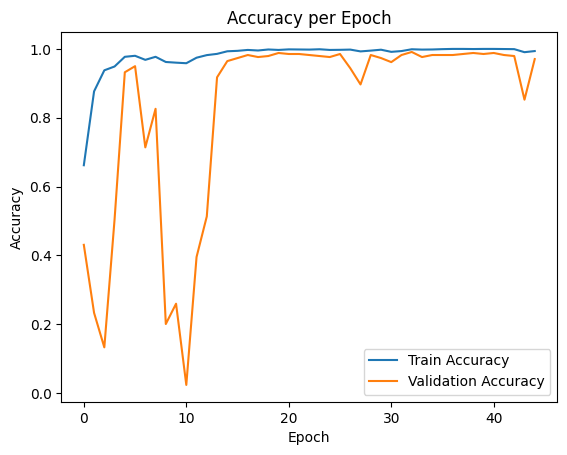

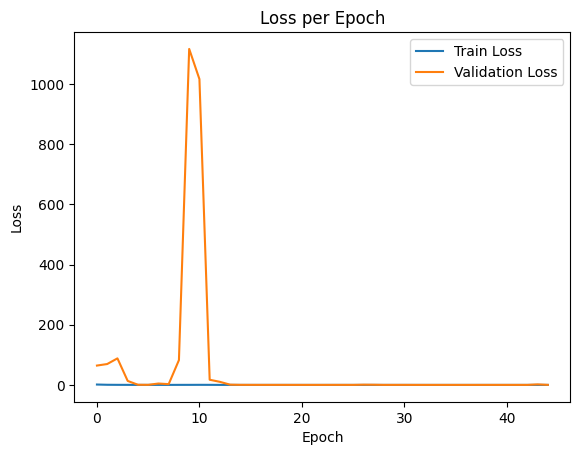

In [ ]:
# Γράφημα ακρίβειας
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Γράφημα απώλειας
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()